### 01 packages

In [112]:
##########################################################################################
##########################################################################################

import networkx as nx

from shapely.geometry import Point,Polygon

import math

import random

##########################################################################################
##########################################################################################

import numpy as np

import pandas as pd

##########################################################################################
##########################################################################################

import matplotlib

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

##########################################################################################
##########################################################################################

from itertools import combinations, permutations

##########################################################################################
##########################################################################################

import copy

##########################################################################################
##########################################################################################

import os

### 02 interior parameters

In [122]:
##########################################################################################
##########################################################################################

Base_speed=int(10000/60) # 10 KM per hour

##########################################################################################
##########################################################################################

alpha=1

speed=alpha*Base_speed

##########################################################################################
##########################################################################################

batch_interval=1

##########################################################################################
##########################################################################################

instance='01'

##########################################################################################
##########################################################################################

lambda_value = 20

pattern='uniform'#'centralized','uniform'

##########################################################################################
##########################################################################################

budget_limit=100

##########################################################################################
##########################################################################################

save_path="./03result/02Dynamic_VRPPD/"+pattern+'_'+str(lambda_value)

if not os.path.exists(save_path):
    
    os.makedirs(save_path)

##########################################################################################
##########################################################################################

Nodes=np.load("./01network/"+instance+"/Nodes.npy")

Edges=np.load("./01network/"+instance+"/Edges.npy")

##########################################################################################
##########################################################################################

Road_Graph = nx.Graph()

for node in Nodes:
    
    node=tuple(node)
        
    Road_Graph.add_node(node)

for edge in Edges:
    
    node1=tuple(edge[0])
    
    node2=tuple(edge[1])
    
    Road_Graph.add_edge(node1, node2, weight=Point(node1).distance(Point(node2)))

### 04 Parcel-Courier assignment

In [123]:
##########################################################################################
##########################################################################################

parcel_df=pd.read_csv('./02data/01/instance_'+str(lambda_value)+'_'+pattern+'.csv')

parcel_df=parcel_df.drop(columns=['Unnamed: 0'])

##########################################################################################
##########################################################################################

parcel_df['pick_up']=parcel_df.apply(lambda x:tuple([round(float(y),2) for y in x.pick_up.replace('(','').replace(')','').split(',')]),axis=1)

parcel_df['drop_off']=parcel_df.apply(lambda x:tuple([round(float(y),2) for y in x.drop_off.replace('(','').replace(')','').split(',')]),axis=1)

##########################################################################################
##########################################################################################

parcel_df['courier_id']='None'

parcel_df['pick_up_time']=-float('inf')

parcel_df['drop_off_time']=-float('inf')

##########################################################################################
##########################################################################################

courier_df=pd.read_csv('./02data/'+instance+'/courier_instance.csv')

courier_df=courier_df.drop(columns=['Unnamed: 0'])

##########################################################################################
##########################################################################################

courier_schedules={}

couriers_parcels_matching={}

for idx,row in courier_df.iterrows():
    
    courier_schedules[row.courier_id]={i:((row.x,row.y),['park']) for i in range(1,batch_interval+1,1)}
    
    couriers_parcels_matching[row.courier_id]=list()

##########################################################################################

parcel_schedules={}

for idx,row in parcel_df.iterrows():
    
    parcel_schedules[row.parcel_id]={}
    
##########################################################################################
##########################################################################################

    
def total_travel_distance(trajectory):
    
    total_distance = 0.0
    
    # Iterate through the trajectory and calculate the distance for each consecutive pair of coordinates
    
    for i in range(len(trajectory) - 1):
        
        total_distance += nx.shortest_path_length(Road_Graph, source=trajectory[i], target=trajectory[i + 1], weight='weight') 
    
    return total_distance

##########################################################################################
##########################################################################################

t=copy.copy(batch_interval)

##########################################################################################
##########################################################################################

dynamic_completions={}

dynamic_distances={}

while True:
    
    ##########################################################################################
    ##########################################################################################
    
    # 01 collect parcels within the batches
    
    collected_parcel=copy.copy(parcel_df.loc[(parcel_df.t_a<=t)&(parcel_df.courier_id=='None')])
    
    parcel_num=collected_parcel.shape[0]
            
    ##########################################################################################
    ##########################################################################################
    
    if parcel_num>0:
        
        ##########################################################################################
        ##########################################################################################
        
        # 02 select parcel with the earliest due time

        collected_parcel=collected_parcel.sort_values(by='t_dl', ascending=True)
        
        idx=collected_parcel.index.to_list()[0]
        
        select_parcel=collected_parcel.loc[idx]
        
        ##########################################################################################
        ##########################################################################################
    
        # 03 get the current time

        parcel_id=select_parcel.parcel_id

        t_a=select_parcel.t_a
        
        pick_up_point=select_parcel.pick_up
        
        drop_off_point=select_parcel.drop_off
        
        ##########################################################################################
        ##########################################################################################
    
        # 04 dynamic insertions
        
        pick_up_times={}
        
        drop_off_times={}
        
        optimal_insertions={}
        
        total_completion_times={}

        for courier_id in courier_schedules.keys():
            
            budget=0

            schedule={k:node for k,node in courier_schedules[courier_id].items() if k>=t}
            
            courier_realse_time=list(schedule.keys())[-1]
                
            courier_realse_point=tuple(list(schedule.values())[-1][0])
            
            visiting_nodes=[node[0] for k,node in schedule.items()]
            
            visiting_timeline=[k for k,node in schedule.items()]
        
            total_completion_time=float('inf')

            for pickup_insert_idx in range(len(visiting_nodes),0,-1):
                
                if budget>budget_limit:
                        
                    break

                pickup_visiting_nodes=copy.copy(visiting_nodes)

                pickup_visiting_nodes.insert(pickup_insert_idx,pick_up_point)

                pick_up_time=copy.copy(visiting_timeline[0])

                for search_idx in range(1,pickup_insert_idx+1,1):

                    pick_up_time+=int(nx.shortest_path_length(Road_Graph, source=pickup_visiting_nodes[search_idx-1], target=pickup_visiting_nodes[search_idx], weight='weight')/speed)

                for drop_insert_idx in range(pickup_insert_idx+1,len(pickup_visiting_nodes)+1,1):
                    
                    if budget>budget_limit:
                        
                        break
                    
                    budget+=1

                    dropoff_visiting_nodes=copy.copy(pickup_visiting_nodes)

                    dropoff_visiting_nodes.insert(drop_insert_idx,drop_off_point)

                    drop_off_time=copy.copy(pick_up_time)

                    for search_idx in range(pickup_insert_idx+1,drop_insert_idx+1,1):

                        drop_off_time+=int(nx.shortest_path_length(Road_Graph, source=dropoff_visiting_nodes[search_idx-1], target=dropoff_visiting_nodes[search_idx], weight='weight')/speed)

                    completion_time=copy.copy(drop_off_time)

                    for search_idx in range(drop_insert_idx+1,len(dropoff_visiting_nodes),1):

                        completion_time+=int(nx.shortest_path_length(Road_Graph, source=dropoff_visiting_nodes[search_idx-1], target=dropoff_visiting_nodes[search_idx], weight='weight')/speed)

                    if completion_time<total_completion_time:

                        optimal_pick_up_time=pick_up_time

                        optimal_drop_off_time=drop_off_time

                        optimal_pick_up_idx=pickup_insert_idx

                        optimal_drop_off_idx=drop_insert_idx

                        total_completion_time=completion_time

            total_completion_times[courier_id]=total_completion_time
                            
            drop_off_times[courier_id]=optimal_drop_off_time
            
            pick_up_times[courier_id]=optimal_pick_up_time
            
            optimal_insertions[courier_id]={'pick_up_idx':optimal_pick_up_idx,'drop_off_idx':optimal_drop_off_idx}
            
        ##########################################################################################
        ##########################################################################################

        select_courier_id=min(total_completion_times, key=total_completion_times.get)
        
        ##########################################################################################
        ##########################################################################################
        
        couriers_parcels_matching[select_courier_id].append(parcel_id)
        
        ##########################################################################################
        ##########################################################################################
                                           
        # 05 extract the courier schedule
        
        select_schedule={k:node for k,node in courier_schedules[select_courier_id].items() if k>=t}
        
        select_courier_realse_time=list(select_schedule.keys())[-1]
                
        select_courier_realse_point=tuple(list(select_schedule.values())[-1][0])
        
        select_visiting_nodes=[node[0] for k,node in select_schedule.items()]
        
        select_visiting_type=[node[1] for k,node in select_schedule.items()]
            
        select_visiting_timeline=[k for k,node in select_schedule.items()]
        
        kept_schedule=copy.copy({k:node for k,node in courier_schedules[select_courier_id].items() if k<t})
        
        ##########################################################################################
        ##########################################################################################
        
        optimal_pick_up_idx=optimal_insertions[select_courier_id]['pick_up_idx']
        
        optimal_drop_off_idx=optimal_insertions[select_courier_id]['drop_off_idx']
        
        ##########################################################################################
        ##########################################################################################
        
        select_visiting_nodes.insert(optimal_pick_up_idx,pick_up_point)

        select_visiting_type.insert(optimal_pick_up_idx,['pick_up_'+parcel_id])
        
        select_visiting_nodes.insert(optimal_drop_off_idx,drop_off_point)

        select_visiting_type.insert(optimal_drop_off_idx,['drop_off_'+parcel_id])
        
        ##########################################################################################
        ##########################################################################################
        
        parcel_schedules[parcel_id][select_courier_id]={}
        
        parcel_schedules[parcel_id][select_courier_id]['pick_up']=(pick_up_point,pick_up_times[select_courier_id])

        parcel_schedules[parcel_id][select_courier_id]['drop_off']=(drop_off_point,drop_off_times[select_courier_id])

        ##########################################################################################
        ##########################################################################################
        
        update_schedule_time=list(select_schedule.keys())[0]
        
        update_schedule_point=tuple(list(select_schedule.values())[0])
        
        update_schedule={update_schedule_time:update_schedule_point}
        
        ##########################################################################################
        ##########################################################################################
    
        update_schedule_time=list(select_schedule.keys())[0]
        
        update_schedule_point=tuple(list(select_schedule.values())[0])
        
        update_schedule={update_schedule_time:update_schedule_point}
    
        for node_idx in range(1,len(select_visiting_nodes),1):
            
            travel_time=int(nx.shortest_path_length(Road_Graph, source=select_visiting_nodes[node_idx-1], target=select_visiting_nodes[node_idx], weight='weight')/speed)
            
            if travel_time==0 and 'park' not in select_visiting_type[node_idx-1] and 'en-route' not in select_visiting_type[node_idx-1] and 'en-route' not in select_visiting_type[node_idx]:
                
                update_schedule[update_schedule_time]=(select_visiting_nodes[node_idx],select_visiting_type[node_idx-1]+select_visiting_type[node_idx])
                
            elif travel_time==0 and 'en-route' in select_visiting_type[node_idx]:
                
                pass
                
            else:
                
                update_schedule_time+=travel_time
                
                update_schedule[update_schedule_time]=(select_visiting_nodes[node_idx],select_visiting_type[node_idx])
        
        ##########################################################################################
        ##########################################################################################
        
        update_schedule_={}
        
        update_trajectory=list(update_schedule.values())
        
        update_stamp=list(update_schedule.keys())
        
        for s_idx in range(1,len(update_trajectory),1):
            
            pre_stamp,pre_loc=update_stamp[s_idx-1],update_trajectory[s_idx-1][0]
            
            cur_stamp,cur_loc=update_stamp[s_idx],update_trajectory[s_idx][0]
            
            update_schedule_[pre_stamp]=update_trajectory[s_idx-1]
            
            intermediate_path=nx.shortest_path(Road_Graph, source=pre_loc, target=cur_loc, weight='weight')
            
            if len(intermediate_path)==2:
                
                update_schedule_[cur_stamp]=update_trajectory[s_idx]
        
            else:
                
                for k in range(1,len(intermediate_path),1):
            
                    distance=nx.shortest_path_length(Road_Graph, source=intermediate_path[k-1], target=intermediate_path[k], weight='weight')

                    travel_time=int(distance/speed)
                    
                    pre_stamp+=travel_time

                    if k==len(intermediate_path)-1:

                        update_schedule_[cur_stamp]=update_trajectory[s_idx]
                        
                    else:
                        
                        update_schedule_[pre_stamp]=(intermediate_path[k],['en-route'])
                
        ##########################################################################################
        ##########################################################################################
        
        kept_schedule.update(update_schedule_)
            
        courier_schedules[select_courier_id]=dict(sorted(kept_schedule.items()))
            
        ##########################################################################################
        ##########################################################################################
        
        parcel_df.loc[(parcel_df['parcel_id']==parcel_id),'courier_id']=select_courier_id
        
        parcel_df.loc[(parcel_df['parcel_id']==parcel_id),'pick_up_time']=pick_up_times[select_courier_id]
        
        parcel_df.loc[(parcel_df['parcel_id']==parcel_id),'drop_off_time']=drop_off_times[select_courier_id]
        
        for time_stamp, node_infos in update_schedule.items():
            
            for node_info in node_infos[1]:
                
                if node_info!='park' and node_info!='en-route':
            
                    node_type=node_info.split('_p')[0]

                    update_parcel_id='p'+node_info.split('_p')[1]

                    if node_type=='pick_up' and update_parcel_id!=parcel_id:

                        parcel_df.loc[(parcel_df['parcel_id']==update_parcel_id),'pick_up_time']=time_stamp
                        
                        parcel_schedules[update_parcel_id][select_courier_id]['pick_up']=(drop_off_point,time_stamp)

                    elif node_type=='drop_off' and update_parcel_id!=parcel_id:

                        parcel_df.loc[(parcel_df['parcel_id']==update_parcel_id),'drop_off_time']=time_stamp
                        
                        parcel_schedules[update_parcel_id][select_courier_id]['drop_off']=(drop_off_point,time_stamp)
    
    ##########################################################################################
    ##########################################################################################
    
    # update the batch time
    
    else:
        
        ##########################################################################################
        ##########################################################################################
        
        if t%10==0:
            
            ttdis=0.0

            for schedules in courier_schedules.values():

                trajectory=list([v[0] for k,v in schedules.items() if k<=t])

                ttdis+=total_travel_distance(trajectory)

            print("*"*100)

            print("Minute is ",t,", Number of completions is ",parcel_df.loc[(parcel_df.drop_off_time>=0)&(t>parcel_df.drop_off_time)].shape[0],\
                  ", Total travel distance(KM) is ",round(ttdis/1000.0,2))
            
            dynamic_completions[t]=parcel_df.loc[(parcel_df.drop_off_time>=0)&(t>parcel_df.drop_off_time)].shape[0]
            
            dynamic_distances[t]=round(ttdis/1000.0,2)

        t=int(t+batch_interval)
        
        ##########################################################################################
        ##########################################################################################

        
        for courier_id,schedules in courier_schedules.items():
            
            courier_realse_time=list(schedules.keys())[-1]
            
            courier_realse_point=tuple(list(schedules.values())[-1][0])
            
            if courier_realse_time<t:
                
                for t_step in range(courier_realse_time+1,t+1,1):
                    
                     courier_schedules[courier_id][t_step]=(courier_realse_point,['park'])
                        
    ##########################################################################################
    ##########################################################################################

    if parcel_df.loc[(parcel_df.courier_id=='None')].empty and t>parcel_df.drop_off_time.max():
    
        break
    
    


****************************************************************************************************
Minute is  10 , Number of completions is  0 , Total travel distance(KM) is  28.0
****************************************************************************************************
Minute is  20 , Number of completions is  1 , Total travel distance(KM) is  84.0
****************************************************************************************************
Minute is  30 , Number of completions is  2 , Total travel distance(KM) is  112.0


KeyboardInterrupt: 

In [ ]:
courier_schedules['c1']

In [ ]:
courier_schedules['c28']

In [ ]:
parcel_df

### 05 save results

In [ ]:
##########################################################################################
##########################################################################################

# 01 save parcel

parcel_df.to_csv(save_path+"/parcel_df_"+str(alpha)+"_"+str(batch_interval)+".csv")

##########################################################################################
##########################################################################################

def generate_trajectory(origin, destination):
    
    # Calculate the total distance
    
    distance = Point(destination).distance(Point(origin))
    
    # Calculate total time
    total_time = distance / speed
    
    # Calculate the number of intervals
    intervals = int(np.floor(total_time))
    
    # Create an array to hold the trajectory
    trajectory = np.zeros((intervals+1, 2))  # Assuming 2D coordinates
    
    for i in range(intervals+1):
        # Interpolate the position for each time interval
        alpha = i / intervals
        trajectory[i] = np.array(origin) * (1 - alpha) + np.array(destination) * alpha

    return trajectory

##########################################################################################
##########################################################################################

# 02 complete trajectory

trajectory_schedules={}

for courier_id,schedules in courier_schedules.items():
    
    completed_schedules={}
    
    stamps=list(schedules.keys())
    
    nodes=list(schedules.values())
    
    completed_schedules[stamps[0]]=nodes[0][0]
    
    for i in range(1,len(stamps),1):
                                         
        completed_schedules[stamps[i]]=nodes[i][0]
        
        pre_t,t=stamps[i-1],stamps[i]
        
        pre_node,node=nodes[i-1][0],nodes[i][0]
        
        if t>pre_t+1:
            
            trajectory=generate_trajectory(pre_node, node)
            
            for j in range(1,len(trajectory)-1,1):
                
                insert_node=tuple([round(x,2) for x in trajectory[j]])
                
                completed_schedules[int(pre_t+j)]=insert_node
                
    completed_schedules = dict(sorted(completed_schedules.items()))
    
    trajectory_schedules[courier_id]=completed_schedules
            
##########################################################################################
##########################################################################################

np.save(save_path+"/courier_schedules_"+str(alpha)+"_"+str(batch_interval),trajectory_schedules)

np.save(save_path+"/parcel_schedules_"+str(alpha)+"_"+str(batch_interval),parcel_schedules)   

##########################################################################################
##########################################################################################

np.save(save_path+"/dynamic_completions_"+str(alpha)+"_"+str(batch_interval),dynamic_completions)

np.save(save_path+"/dynamic_distances_"+str(alpha)+"_"+str(batch_interval),dynamic_distances)   


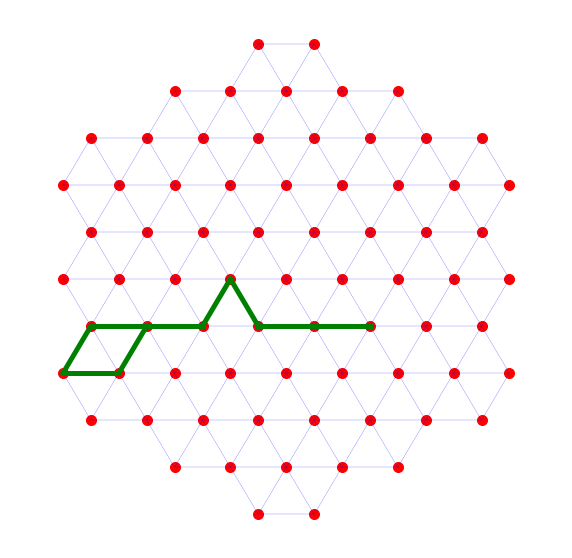

In [111]:
figsize = 10,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 15}

figure, axs = plt.subplots(figsize=figsize)

labels = axs.get_xticklabels() + axs.get_yticklabels()

[label.set_fontsize(15) for label in labels]

[label.set_fontname('Arial') for label in labels]
    
axs.set_xlabel('X',font_label)

axs.set_ylabel('Y',font_label)

axs.set_xlim([-5000,5000])

axs.set_ylim([-5000,5000])

for edge in Road_Graph.edges:
    
    axs.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]], color='blue',linewidth=.2,linestyle='-')

# for vertice in Hexagon_Vertices.values():
    
#     hexagon = matplotlib.patches.Polygon(vertice, closed=True, edgecolor='blue', facecolor='lightblue',alpha=0.5)
    
#     axs.add_patch(hexagon)

    
# for hexagon_id, center in Hexagon_Center.items():
    
#     axs.text(center[0], center[1], hexagon_id, fontsize=20, color='black')

for node in Road_Graph.nodes:
    
        
    axs.scatter(node[0], node[1], color='red',s=100,alpha=1)


path=list([v[0] for k,v in courier_schedules['c28'].items()])

# path=visiting_nodes['c3']

for i in range(1,len(path),1):
    
    axs.plot([path[i-1][0],path[i][0]],[path[i-1][1],path[i][1]], color='green',linewidth=5,linestyle='-',alpha=1)
    


    
# Hide the x and y axes
plt.axis('off')

plt.show()